In [1]:
import os
import sys

import pandas as pd
import numpy as np

from PIL import Image

import torch
import torch.nn as nn
import torch.nn.functional as F

from torchvision.utils import save_image
from torch.utils.data import Dataset, DataLoader

from torchvision import transforms, utils
from torchvision.utils import make_grid

import matplotlib.pyplot as plt
from tqdm.auto import tqdm

## Данные и модель

In [2]:
from dataset import ArchDataset, GT_NEGATIVE_PATHS, GT_POSITIVE_PATHS, GT_NEGATIVE_COORDS, GT_POSITIVE_COORDS

In [3]:
from model import VQVAE

# Параметры модели и обучения

In [4]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

In [5]:
results_dir = 'v6'

checkpoint_path = f'{results_dir}/checkpoint_14.pth'

In [6]:
params = {
    'batch_size': 1,
    'img_size': 64,
    'channels': 1,
    'embedding_dim': 64,
    'num_embeddings': 64,
    'beta': 0.25,
    'n_epochs': 15,  # 10
}

# Датасет

In [7]:
transform_crop_64_grayscale = transforms.Compose([
    transforms.CenterCrop((64, 64)),
    transforms.Grayscale(),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])

In [8]:
train_dataset = ArchDataset(
    img_paths=GT_NEGATIVE_PATHS, 
    coords=GT_NEGATIVE_COORDS, 
    anomalies=False, 
    transform=transform_crop_64_grayscale
)
train_loader = DataLoader(train_dataset, batch_size=params['batch_size'], shuffle=True)

anomalies_dataset = ArchDataset(
    img_paths=GT_POSITIVE_PATHS, 
    coords=GT_POSITIVE_COORDS, 
    anomalies=False, 
    transform=transform_crop_64_grayscale
)
anomalies_loader = DataLoader(anomalies_dataset, batch_size=params['batch_size'], shuffle=False)

In [9]:
print(f'train: {len(train_dataset)} images, {len(train_loader)} batches')
print(f'anomalies: {len(anomalies_dataset)} images, {len(anomalies_loader)} batches')

train: 139945 images, 139945 batches
anomalies: 163 images, 163 batches


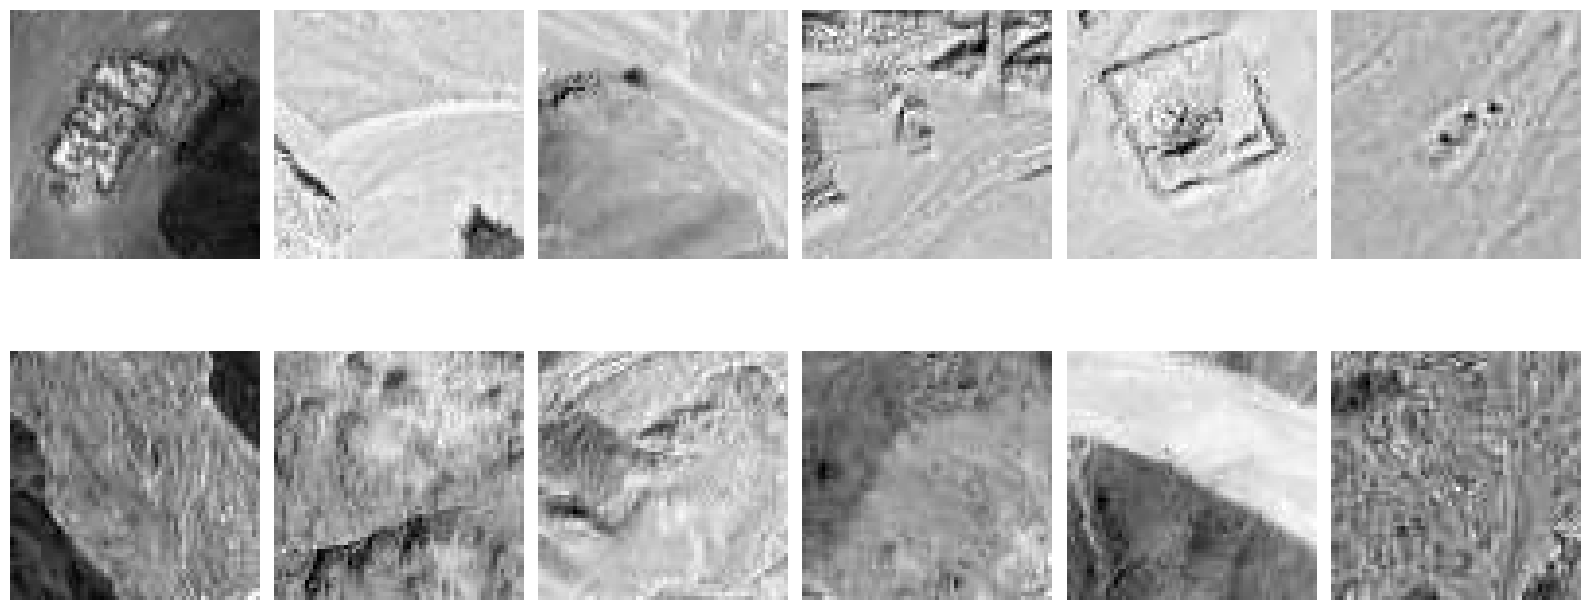

In [10]:
ncols = 6

fig, axs = plt.subplots(nrows=2, ncols=ncols, figsize=(16, 8))
for i in range(ncols):
    axs[0, i].axis('off')
    axs[1, i].axis('off')
    axs[0, i].imshow((anomalies_dataset[i][0].permute(1, 2, 0) + 1) / 2, cmap='gray')
    axs[1, i].imshow((train_dataset[i][0].permute(1, 2, 0) + 1) / 2, cmap='gray')
fig.tight_layout()
fig.show()

# Модель

In [11]:
model = VQVAE(
    in_channels=params['channels'],
    img_size=params['img_size'],
    
    embedding_dim=params['embedding_dim'],
    num_embeddings=params['num_embeddings'],
    beta=params['beta']
)

model.load_state_dict(torch.load(checkpoint_path, map_location=device))

<All keys matched successfully>

# Смотрим

In [12]:
import lpips
loss_fn_alex = lpips.LPIPS(net='alex')

from torchvision.models import vit_b_16, ViT_B_16_Weights


weights = ViT_B_16_Weights.IMAGENET1K_V1
vit_model = vit_b_16(weights=weights)

vit_model.heads = torch.nn.Identity()
vit_model.eval();

from sklearn.metrics.pairwise import cosine_similarity

Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /tmp/xdg_cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth
100%|██████████| 233M/233M [00:03<00:00, 63.0MB/s] 


Loading model from: /home/jupyter/.local/lib/python3.10/site-packages/lpips/weights/v0.1/alex.pth


Downloading: "https://download.pytorch.org/models/vit_b_16-c867db91.pth" to /tmp/xdg_cache/torch/hub/checkpoints/vit_b_16-c867db91.pth
100%|██████████| 330M/330M [00:04<00:00, 69.6MB/s] 


In [75]:
def load_image(names):
    imgs = []
    for name in names:
        img = transform_crop_64_grayscale(Image.open(name).convert('RGB'))
        imgs.append(img)
    return imgs

def align_image(img):
    return (img - img.min()) / (img.max() - img.min())

def draw_image(imgs):
    fig, axes = plt.subplots(ncols=len(imgs) , figsize=(len(imgs) * 2, 2))

    if len(imgs) == 1:
        img = imgs[0]
        cmap = 'gray' if img.shape[0] == 1 else None
        axes.imshow(align_image(img).permute(1, 2, 0), cmap=cmap)
    else:
        for i, img in enumerate(imgs):
            cmap = 'gray' if img.shape[0] == 1 else None
            axes[i].imshow(align_image(img).permute(1, 2, 0), cmap=cmap)
    plt.show()

In [76]:
def vit_cosine_similarity(img1, img2):

    assert len(img1.shape) == len(img2.shape) == 3,\
        f'expected images of shape C x W x H, got {img1.shape=} {img2.shape=}'

    assert img1.shape[0] == img2.shape[0],\
        f'different number of channels: {img1.shape[0]=} {img2.shape[0]=}'
    

    if img1.shape[0] == 1:  # grayscale
        img1 = img1.repeat(3, 1, 1)
        img2 = img2.repeat(3, 1, 1)

    resize = transforms.Resize(size=224, antialias=True)

    img1 = resize(img1.unsqueeze(0))
    img2 = resize(img2.unsqueeze(0))

    features1 = vit_model(img1).detach().numpy()
    features2 = vit_model(img2).detach().numpy()

    sim = cosine_similarity(features1, features2)
    return sim[0, 0].item()


In [77]:
@torch.no_grad()
def apply_model(model, n_neg=2, n_pos=2, other_image_names=['cat.png']):
    
    negative_examples = torch.stack([train_dataset[i][0].to(device) for i in np.random.randint(0, 100, n_neg)], dim=0)
    positive_examples = torch.stack([anomalies_dataset[i][0].to(device) for i in np.random.randint(0, 100, n_pos)], dim=0)
    other_examples =  torch.stack([anomaly.to(device) for anomaly in load_image(other_image_names)], dim=0)

    examples = torch.concat((negative_examples, positive_examples, other_examples), dim=0)
    
    print(f'{len(examples)=}')
    
    reconstructions = model(examples)[0]

    titles = ['train' for _ in range(n_neg)] + ['anomaly' for _ in range(n_pos)] + ['extra' for _ in range(len(other_image_names))]
    return examples, reconstructions, titles



In [78]:
@torch.no_grad()
def anomaly_detection(examples, reconstructions, titles, img_path=None):
    ncols = len(examples)
    nrows = 2
    fig, axes = plt.subplots(ncols=ncols, nrows=nrows, figsize=(6 * ncols, 6 * nrows))

    data = torch.cat([examples[None], reconstructions[None]], dim=0)
    print(data.shape)
    for row in range(nrows):
        for col in range(ncols):
            if row == 1:
                
                axes[row - 1, col].set_title(f'{titles[col]}')

                similarity_cosine = vit_cosine_similarity(data[row - 1, col].to('cpu'), data[row, col].to('cpu'))
                similarity_lpips = loss_fn_alex(data[row - 1, col].to('cpu'), data[row, col].to('cpu'))[0, 0, 0, 0].item()
                axes[row, col].set_title(f'lpips: {np.round(similarity_lpips, 2)} cosine: {np.round(similarity_cosine, 2)}')
            
            cmap = 'gray' if data[row, col].shape[0] == 1 else None
            axes[row, col].imshow(align_image(data[row, col].to('cpu')).permute(1, 2, 0), cmap=cmap)
            axes[row, col].axis('off')
            
    if img_path:
        plt.savefig(img_path)
    
    plt.show();
    


In [79]:
examples, reconstructions, titles = apply_model(model, 6, 6)

len(examples)=13


torch.Size([2, 13, 1, 64, 64])


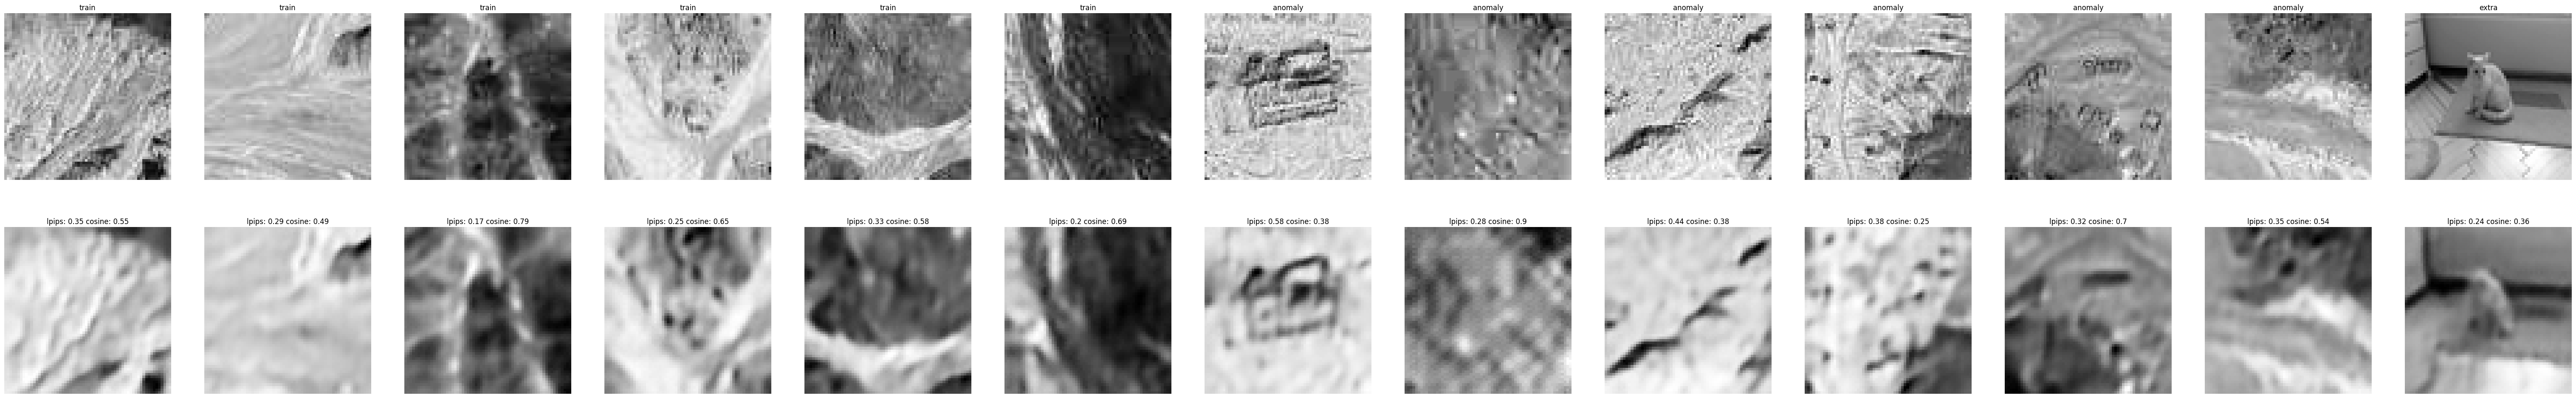

In [80]:
anomaly_detection(examples, reconstructions, titles, img_path='res_064_grayscale')